In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
modelo=pd.read_csv('data/modelo.csv',low_memory=False)

In [3]:
modelo.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-18 00:11:59,viewed product,4886f805,NaN,9288.0,Samsung Galaxy J7 Prime,Excelente,32GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-18 00:11:27,viewed product,ad93850f,NaN,304.0,iPhone 5s,Muito Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-05-18 00:11:16,viewed product,0297fc1e,NaN,6888.0,iPhone 6S,Muito Bom,64GB,Prateado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-18 00:11:14,viewed product,2d681dd8,NaN,11890.0,iPhone 7,Bom,128GB,Vermelho,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-18 00:11:09,viewed product,cccea85e,NaN,7517.0,LG G4 H818P,Excelente,32GB,Branco,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
modelo.drop(['url', 'sku', 'skus','channel','staticpage','condition','storage','color','search_engine','device_type','campaign_source','country','region','search_term','new_vs_returning','city','region','screen_resolution','operating_system_version','browser_version'], axis=1, inplace=True)

In [5]:
training= pd.read_csv('data/training.csv',low_memory=False)

# Armado del modelo

In [6]:
modelo.sort_values('person',inplace=True)

In [7]:
import calendar

modelo['timestamp'] = pd.to_datetime(modelo['timestamp'])


modelo['dia']=modelo['timestamp'].dt.dayofyear
modelo['dias_distintos'] = modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month==5) & ( modelo['timestamp'].dt.day>23) ] )['dia'].nunique().unstack()[True])   
modelo['dias_distintos']=modelo['dias_distintos'].fillna(0).astype(int)
modelo.drop('dia',1,inplace=True)



modelo['modelos_distintos_vistos']= modelo['person'].map( modelo.groupby('person')['model'].nunique())
modelo.drop('model',1,inplace=True)


modelo['campaña_ultima_semana']=modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month==5) & (modelo['timestamp'].dt.day>23) & (modelo['event']=="ad campaign hit")]).size().unstack()[True]) 
modelo['campaña_ultima_semana']=modelo['campaña_ultima_semana'].fillna(0).astype(int)


modelo['busqueda_celular']=modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month==5) & (modelo['timestamp'].dt.day>23) & (modelo['event']=="searched products")]).size().unstack()[True]) 
modelo['busqueda_celular']=modelo['busqueda_celular'].fillna(0).astype(int)


modelo['total_visitas_usuario'] = modelo.groupby('person')['person'].transform('count')


modelo['visitas_ultimo_mes']=modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month)==5]).size().unstack()[True])
modelo['visitas_ultimo_mes']=modelo['visitas_ultimo_mes'].fillna(0).astype(int)


modelo['visitas_ultimos_15']=modelo['person'].map(modelo.groupby(['person', (modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>15)]).size().unstack()[True])
modelo['visitas_ultimos_15']=modelo['visitas_ultimos_15'].fillna(0).astype(int)


modelo['visitas_ultima_semana']=modelo['person'].map(modelo.groupby(['person', (modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>23)]).size().unstack()[True])
modelo['visitas_ultima_semana']=modelo['visitas_ultima_semana'].fillna(0).astype(int)

modelo['visitas_ultimos_3']=modelo['person'].map(modelo.groupby(['person', (modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>27)]).size().unstack()[True])
modelo['visitas_ultimos_3']=modelo['visitas_ultimos_3'].fillna(0).astype(int)


modelo['total_checkout']=modelo['person'].map(modelo.groupby(['person','event']).size().unstack()['checkout'])
modelo['total_checkout']=modelo['total_checkout'].fillna(0).astype(int)



modelo['checkouts_ultimo_mes']=modelo['person'].map(modelo.groupby(['person','event',modelo['timestamp'].dt.month==5 ]).size().unstack()[True].unstack()['checkout'])   
modelo['checkouts_ultimo_mes']=modelo['checkouts_ultimo_mes'].fillna(0).astype(int)


"""
modelo['checkouts_ultima_semana']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>23)]).size().unstack()[True].unstack()['checkout'])
modelo['checkouts_ultima_semana']=modelo['checkouts_ultima_semana'].fillna(0).astype(int)



modelo['total_compras']=modelo['person'].map(modelo.groupby(['person','event']).size().unstack()['conversion'])
modelo['total_compras']=modelo['total_compras'].fillna(0).astype(int)



modelo['compras_ultimo_mes']=modelo['person'].map(modelo.groupby(['person','event',modelo['timestamp'].dt.month==5 ]).size().unstack()[True].unstack()['conversion'])
modelo['compras_ultimo_mes']=modelo['compras_ultimo_mes'].fillna(0).astype(int)



modelo['compras_ultima_semana']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>23)]).size().unstack()[True].unstack()['conversion'])
modelo['compras_ultima_semana']=modelo['compras_ultima_semana'].fillna(0).astype(int)


modelo['subscripciones_ultimo_mes']=modelo['person'].map(modelo.groupby(['person','event',modelo['timestamp'].dt.month==5 ]).size().unstack()[True].unstack()['lead'])
modelo['subscripciones_ultimo_mes']=modelo['subscripciones_ultimo_mes'].fillna(0).astype(int)
"""


"\nmodelo['checkouts_ultima_semana']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>23)]).size().unstack()[True].unstack()['checkout'])\nmodelo['checkouts_ultima_semana']=modelo['checkouts_ultima_semana'].fillna(0).astype(int)\n\n\n\nmodelo['total_compras']=modelo['person'].map(modelo.groupby(['person','event']).size().unstack()['conversion'])\nmodelo['total_compras']=modelo['total_compras'].fillna(0).astype(int)\n\n\n\nmodelo['compras_ultimo_mes']=modelo['person'].map(modelo.groupby(['person','event',modelo['timestamp'].dt.month==5 ]).size().unstack()[True].unstack()['conversion'])\nmodelo['compras_ultimo_mes']=modelo['compras_ultimo_mes'].fillna(0).astype(int)\n\n\n\nmodelo['compras_ultima_semana']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>23)]).size().unstack()[True].unstack()['conversion'])\nmodelo['compras_ultima_semana']=modelo['compras_

In [8]:
modelo=modelo.drop_duplicates(subset=['person'])
modelo.drop(['timestamp','event'], 1, inplace=True)

In [9]:
modelo=pd.merge(modelo, training, on='person', how='left')

In [10]:
modelo.head()

,person,dias_distintos,modelos_distintos_vistos,campaña_ultima_semana,busqueda_celular,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,label
0,0008ed71,0,3,0,0,6,6,6,0,0,3,3,0.0
1,00091926,4,36,6,0,448,448,261,47,19,2,2,NaN
2,00091a7a,0,3,0,0,10,0,0,0,0,0,0,NaN
3,000ba417,2,26,0,0,206,206,206,138,0,6,6,NaN
4,000c79fe,1,1,1,9,17,17,17,17,17,1,1,0.0


In [11]:
a_predecir=modelo[modelo['label'].isnull()]
a_predecir.head()

,person,dias_distintos,modelos_distintos_vistos,campaña_ultima_semana,busqueda_celular,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,label
1,00091926,4,36,6,0,448,448,261,47,19,2,2,NaN
2,00091a7a,0,3,0,0,10,0,0,0,0,0,0,NaN
3,000ba417,2,26,0,0,206,206,206,138,0,6,6,NaN
5,000e4d9e,5,37,0,0,411,411,411,112,75,1,1,NaN
6,000e619d,0,23,0,0,68,68,58,0,0,1,1,NaN


In [12]:
modelo.drop(modelo[modelo['label'].isnull()].index,inplace=True)
modelo['label']=modelo['label'].astype(int)
modelo.head()

,person,dias_distintos,modelos_distintos_vistos,campaña_ultima_semana,busqueda_celular,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,label
0,0008ed71,0,3,0,0,6,6,6,0,0,3,3,0
4,000c79fe,1,1,1,9,17,17,17,17,17,1,1,0
10,001802e4,1,2,5,4,19,19,19,19,19,1,1,0
12,0019e639,0,26,0,0,471,290,136,0,0,15,4,0
14,001b0bf9,0,1,0,0,7,7,7,0,0,2,2,0


In [13]:
len(modelo[modelo['label']==1]),len(modelo[modelo['label']==0]) 

(980, 18434)

In [14]:
len(modelo[modelo['label']==1])*100/len(modelo['label']),len(modelo[modelo['label']==0])*100/len(modelo['label'])

(5.047903574739879, 94.95209642526012)

In [15]:
modelo[modelo['label']==1].head()

,person,dias_distintos,modelos_distintos_vistos,campaña_ultima_semana,busqueda_celular,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,label
31,003476c0,0,2,0,0,43,14,0,0,0,0,0,1
38,003d4cac,0,2,0,0,8,0,0,0,0,1,0,1
39,003dd965,0,0,0,0,5,5,5,0,0,0,0,1
43,0042421c,0,5,0,0,22,0,0,0,0,0,0,1
57,006671fd,0,5,0,0,18,0,0,0,0,0,0,1


In [16]:
modelo[modelo['label']==0].head()

,person,dias_distintos,modelos_distintos_vistos,campaña_ultima_semana,busqueda_celular,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,label
0,0008ed71,0,3,0,0,6,6,6,0,0,3,3,0
4,000c79fe,1,1,1,9,17,17,17,17,17,1,1,0
10,001802e4,1,2,5,4,19,19,19,19,19,1,1,0
12,0019e639,0,26,0,0,471,290,136,0,0,15,4,0
14,001b0bf9,0,1,0,0,7,7,7,0,0,2,2,0


In [17]:
modelo[modelo['label']==1].mean()-modelo[modelo['label']==0].mean()

dias_distintos               0.280920
modelos_distintos_vistos     3.446072
campaña_ultima_semana        0.343258
busqueda_celular             0.586515
total_visitas_usuario       43.553997
visitas_ultimo_mes          16.661781
visitas_ultimos_15           9.752915
visitas_ultima_semana       10.056608
visitas_ultimos_3            8.237521
total_checkout               0.165994
checkouts_ultimo_mes        -0.411831
label                        1.000000
dtype: float64

## MACHINE LEARNING

In [18]:
##Ahora empieza ML

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score

In [19]:
#Agarro 200 casos que compraron ,y 200 que no compraron , y armo un test aparte
from sklearn.utils import shuffle

df1=modelo.loc[modelo['label']==1]
df1=shuffle(df1)
df1=df1.iloc[:200]
modelo.drop(df1.index,inplace=True)
df2=modelo.loc[modelo['label']==0]
df2=shuffle(df2)
df2=df2.iloc[:200]
modelo.drop(df2.index,inplace=True)
df=df1.append(df2, ignore_index=True)
df = shuffle(df)
xtest=df.drop(['person','label'], axis=1)
ytest=df['label']

## Resample

In [20]:
from sklearn.utils import resample
df_minority_upsampled = resample(modelo[modelo['label']==1], 
                                 replace=True,     # sample with replacement
                                 n_samples=18434,    # to match majority class
                                 random_state=123) # reproducible results
modelo = pd.concat([modelo[modelo['label']==0], df_minority_upsampled])

In [21]:
X = modelo.drop(['person','label'], axis=1)
y = modelo['label']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2) 

In [23]:
len(X_train),len(X_test),len(y_train),len(y_test)

(29334, 7334, 29334, 7334)

In [24]:
X_train.head()

,dias_distintos,modelos_distintos_vistos,campaña_ultima_semana,busqueda_celular,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes
28270,0,0,0,0,18,18,0,0,0,0,0
21269,1,1,1,0,13,3,3,3,3,0,0
36648,3,2,4,0,19,19,19,19,19,1,1
4873,0,6,0,0,20,20,20,0,0,1,1
13445,2,2,3,0,8,8,8,8,8,0,0


In [25]:
y_train.head()

28270    1
21269    1
36648    1
4873     0
13445    0
Name: label, dtype: int32

In [26]:
X_test.head()

,dias_distintos,modelos_distintos_vistos,campaña_ultima_semana,busqueda_celular,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes
6992,1,17,0,1,55,55,55,16,16,0,0
25727,0,1,0,0,4,4,4,0,0,1,1
36371,0,8,0,0,94,24,24,0,0,0,0
3154,1,4,0,0,19,19,19,19,19,0,0
1063,1,5,1,0,31,31,31,20,0,1,1


In [27]:
y_test.head()

6992     1
25727    0
36371    1
3154     1
1063     1
Name: label, dtype: int32

In [28]:
len(y_test[y_test == 1]),len(y_test[y_test == 0])

(3661, 3673)

## Algoritmos de clasificación

## KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier
my_classifier= KNeighborsClassifier()
my_classifier.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

## DECISION TREE

In [30]:
from sklearn import tree
my_classifier2= tree.DecisionTreeClassifier()
my_classifier2.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## RANDOM FOREST

In [31]:
from sklearn.ensemble import RandomForestClassifier
my_classifier3 = RandomForestClassifier(n_estimators=5000, max_leaf_nodes=16, n_jobs=-1, random_state=42)
my_classifier3.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Logistic regression

In [32]:
from sklearn.linear_model import LogisticRegression
my_classifier4 = LogisticRegression()
my_classifier4.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Neuronal Network

In [33]:
from sklearn.neural_network import MLPClassifier
my_classifier5 = MLPClassifier(max_iter=100000,hidden_layer_sizes=(100,100,100), )
my_classifier5.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

## Naive Bayes

In [34]:
from sklearn.naive_bayes import GaussianNB
my_classifier6 = GaussianNB()
my_classifier6.fit(X_train,y_train)

GaussianNB(priors=None)

## SVM

In [35]:
from sklearn import svm
my_classifier7 =svm.SVC()
my_classifier7.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## AdaBoost

In [36]:
from sklearn.ensemble import AdaBoostClassifier
my_classifier8 = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
my_classifier8.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

## Resultados

In [37]:
clasificadores={"KNN": my_classifier , "Decision Tree": my_classifier2, "Random Forest": my_classifier3, "Logistic regression": my_classifier4,"Neuronal Network":my_classifier5,
                "Naive Bayes":my_classifier6, "SVM":my_classifier7,"Ada boost": my_classifier8}
resultados={}
for key,value in clasificadores.items():
    prediction=value.predict(X_test)
    matrix=metrics.confusion_matrix(y_test, prediction)
    resultados[key]=[accuracy_score(y_test, prediction),f1_score(y_test, prediction, average='weighted'),precision_score(y_test, prediction, average='weighted'),recall_score(y_test, prediction, average='weighted'),
    roc_auc_score(y_test, prediction),matrix[0][0],matrix[0][1],matrix[1][0],matrix[1][1]  ]
resultados['Metric']=["Accuracy","F1 Score","Precision","Recall","ROC AUC Score","Aciertos 0","No aciertos 0","No aciertos 1","Aciertos 1"]
resultados= pd.DataFrame(resultados)
resultados.set_index('Metric',inplace=True)
resultados

,KNN,Decision Tree,Random Forest,Logistic regression,Neuronal Network,Naive Bayes,SVM,Ada boost
Metric,,,,,,,,
Accuracy,0.928825,0.961958,0.806518,0.646441,0.897737,0.560267,0.957867,0.798609
F1 Score,0.928521,0.961909,0.806265,0.641192,0.897487,0.504026,0.957828,0.798607
Precision,0.936440,0.964461,0.808224,0.655272,0.901799,0.609119,0.959696,0.798630
Recall,0.928825,0.961958,0.806518,0.646441,0.897737,0.560267,0.957867,0.798609
ROC AUC Score,0.928932,0.962018,0.806578,0.646244,0.897818,0.559717,0.957919,0.798615
Aciertos 0,3170.000000,3399.000000,2828.000000,2817.000000,3114.000000,3292.000000,3403.000000,2920.000000
No aciertos 0,503.000000,274.000000,845.000000,856.000000,559.000000,381.000000,270.000000,753.000000
No aciertos 1,19.000000,5.000000,574.000000,1737.000000,191.000000,2844.000000,39.000000,724.000000
Aciertos 1,3642.000000,3656.000000,3087.000000,1924.000000,3470.000000,817.000000,3622.000000,2937.000000


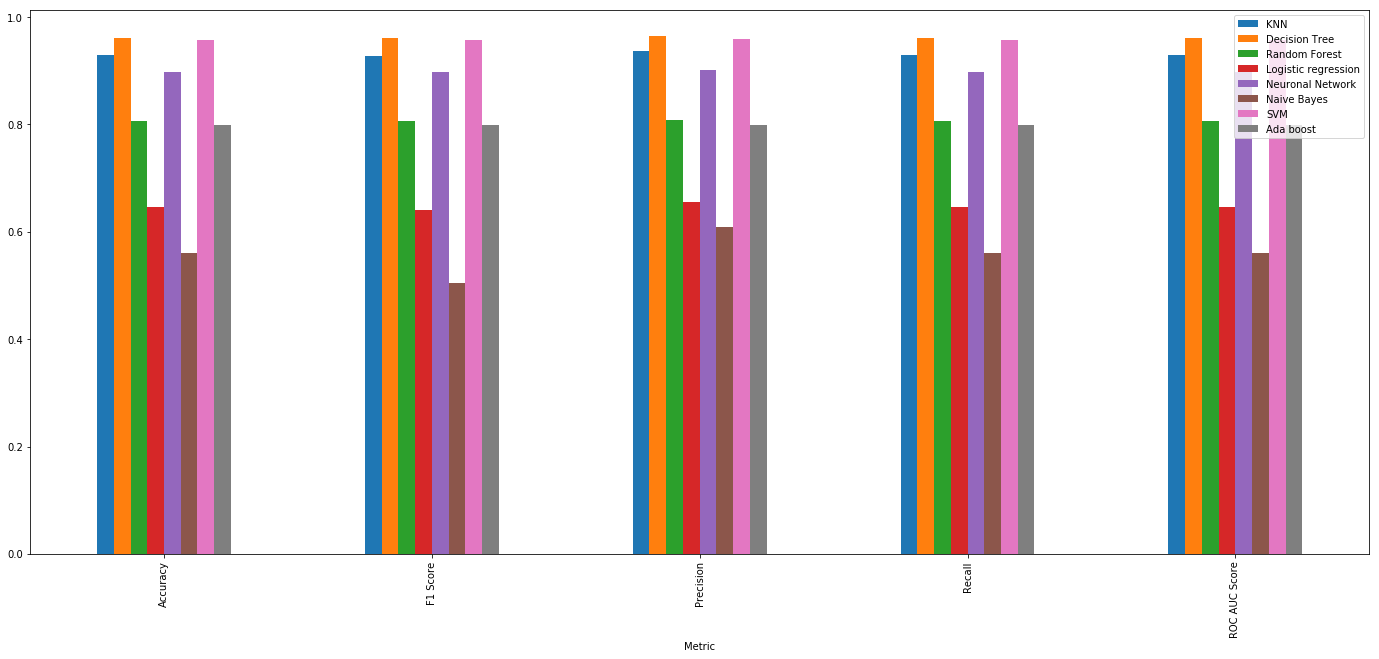

In [38]:
resultados.iloc[:5].plot(kind='bar',figsize=(24,10))

In [39]:
resultados2={}
for key,value in clasificadores.items():
    prediction=value.predict(xtest)
    matrix=metrics.confusion_matrix(ytest, prediction)
    resultados2[key]=[accuracy_score(ytest, prediction),f1_score(ytest, prediction, average='weighted'),precision_score(ytest, prediction, average='weighted'),recall_score(ytest, prediction, average='weighted'),
    roc_auc_score(ytest, prediction),matrix[0][0],matrix[0][1],matrix[1][0],matrix[1][1]  ]
resultados2['Metric']=["Accuracy","F1 Score","Precision","Recall","ROC AUC Score","Aciertos 0","No aciertos 0","No aciertos 1","Aciertos 1"]
resultados2= pd.DataFrame(resultados2)
resultados2.set_index('Metric',inplace=True)
resultados2

,KNN,Decision Tree,Random Forest,Logistic regression,Neuronal Network,Naive Bayes,SVM,Ada boost
Metric,,,,,,,,
Accuracy,0.580000,0.585000,0.780000,0.627500,0.687500,0.545000,0.580000,0.757500
F1 Score,0.552000,0.519175,0.779950,0.621344,0.677334,0.472830,0.519437,0.756830
Precision,0.606667,0.687887,0.780252,0.636367,0.714537,0.599469,0.661323,0.760371
Recall,0.580000,0.585000,0.780000,0.627500,0.687500,0.545000,0.580000,0.757500
ROC AUC Score,0.580000,0.585000,0.780000,0.627500,0.687500,0.545000,0.580000,0.757500
Aciertos 0,166.000000,191.000000,159.000000,151.000000,173.000000,183.000000,187.000000,162.000000
No aciertos 0,34.000000,9.000000,41.000000,49.000000,27.000000,17.000000,13.000000,38.000000
No aciertos 1,134.000000,157.000000,47.000000,100.000000,98.000000,165.000000,155.000000,59.000000
Aciertos 1,66.000000,43.000000,153.000000,100.000000,102.000000,35.000000,45.000000,141.000000


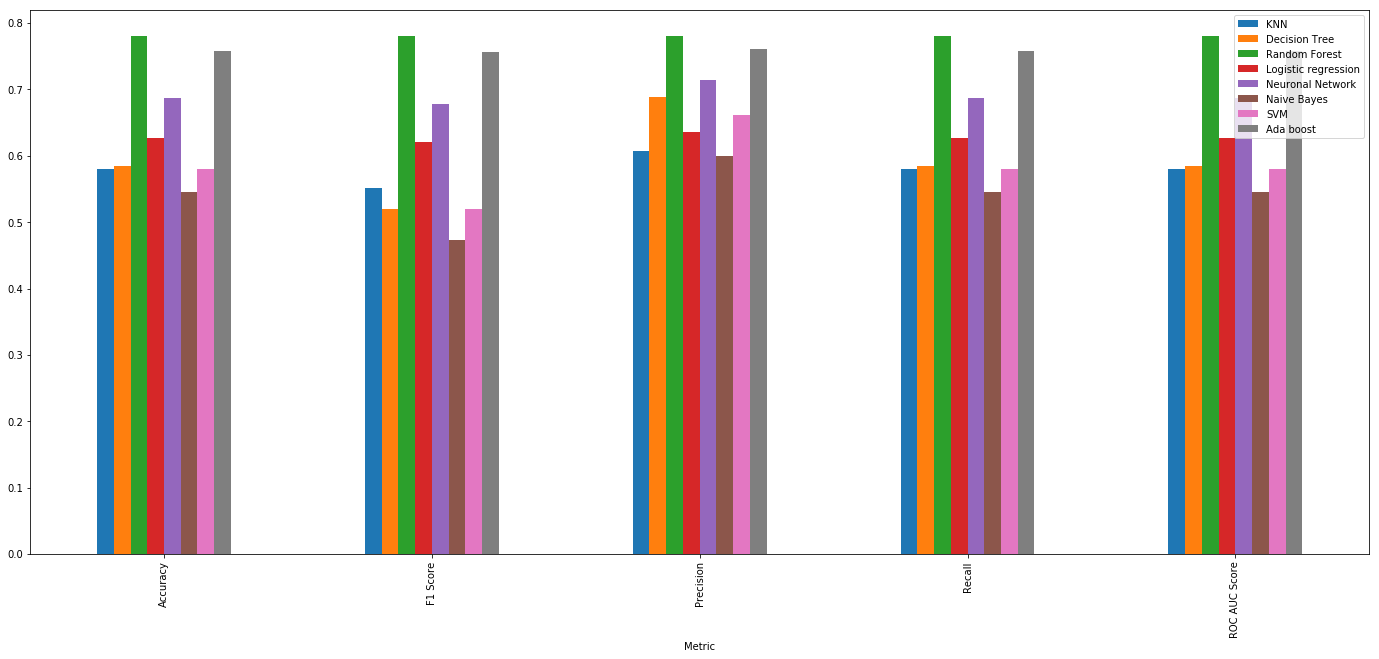

In [40]:
resultados2.iloc[:5].plot(kind='bar',figsize=(24,10))

## Voting Classifier

In [41]:
from sklearn.ensemble import VotingClassifier
vclf1 = VotingClassifier(estimators=[('KNN', my_classifier), ('DT', my_classifier2), ('MLP', my_classifier5)], voting='soft', n_jobs =-1)
vclf1 = vclf1.fit(X_train, y_train)
predictions = vclf1.predict(X_test)
accuracy_score(y_test, predictions)

d:\programas\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9599127352058904

In [42]:
f1_score(y_test, predictions, average='weighted'),precision_score(y_test, predictions, average='weighted'),recall_score(y_test, predictions, average='weighted')

(0.9598697896807994, 0.96199583669743, 0.9599127352058904)

In [43]:
metrics.confusion_matrix(y_test, predictions)

array([[3403,  270],
       [  24, 3637]], dtype=int64)

In [61]:
vclf2 = VotingClassifier(estimators=[  ('RF', my_classifier3), ('ADA', my_classifier8)], voting='soft', n_jobs =-1)
vclf2 = vclf2.fit(X_train, y_train)
predictions2 = vclf2.predict(xtest)
accuracy_score(ytest, predictions2)

d:\programas\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7775

In [62]:
f1_score(ytest, predictions2, average='weighted'),precision_score(ytest, predictions2, average='weighted'),recall_score(ytest, predictions2, average='weighted')

(0.7774318385005408, 0.7778403544341819, 0.7775)

In [63]:
metrics.confusion_matrix(ytest, predictions2)

array([[159,  41],
       [ 48, 152]], dtype=int64)

## KAGGLE PREDICTIONS

In [47]:
kaggle= pd.read_csv('data/kaggle.csv',low_memory=False)

In [48]:
kaggle=pd.merge(kaggle, a_predecir, on='person', how='inner')

In [49]:
kaggle.head()

,person,dias_distintos,modelos_distintos_vistos,campaña_ultima_semana,busqueda_celular,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,label
0,4886f805,0,1,0,0,9,9,9,0,0,1,1,NaN
1,0297fc1e,4,15,1,0,567,173,126,53,8,7,2,NaN
2,2d681dd8,1,3,1,1,26,26,26,16,0,1,1,NaN
3,cccea85e,4,57,5,1,836,836,449,270,252,1,1,NaN
4,4c8a8b93,0,9,0,0,257,257,257,0,0,2,2,NaN


In [50]:
np.savetxt("predictions.csv", my_classifier2.predict_proba(kaggle.drop(['person','label'], axis=1))  , delimiter=",")

In [51]:
unique, counts = np.unique(my_classifier2.predict(kaggle.drop(['person','label'], axis=1)), return_counts=True)
dict(zip(unique, counts))

{0: 17807, 1: 1608}